In [1]:
import numpy as np
from cvxopt import matrix, solvers, log, exp
import matplotlib.pyplot as plt

from matplotlib import style
import matplotlib
plt.style.use('ggplot')
matplotlib.rcParams.update({"axes.grid" : False})

from PyomoSolver import PyomoSolver

### set up problem

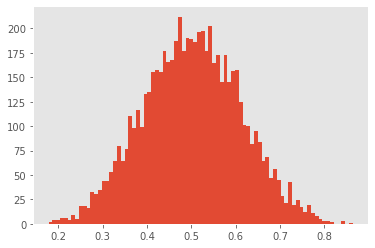

In [2]:
N = 80
M = 80
T = 500

# noise sub-gaussianity parameter
eta = 1
# maximum value of R
max_R = 1

R_true = np.random.beta(10, 10, size=(N, M))

plt.hist(R_true.flatten(), bins=np.int32(np.sqrt(N * M)))
plt.show()
# _, s, _ = np.linalg.svd(R_true)
# plt.yscale("log")
# plt.plot(s)
# plt.show()

### set static capacities

In [3]:
# capacities
C = np.ones(M)
# demands
D = np.ones(N)

### ILP Solver

In [4]:
solver = PyomoSolver(N, M, C, D)

In [5]:
def shift_prices(R, x, p):
    p_extended = np.tile(p,(N, 1))
    margin = x * (R - p_extended) + (1 - x) * max_R
    min_margin = np.min(margin)
    return p + np.maximum(min_margin, 0) - 1e-15

In [6]:
def get_offerings_and_prices(R):
    x = solver.solve_system(R)
    p = solver.get_prices()
    p = p - 1e-6
    return x, p

In [7]:
def filter_decisions(x, p):
    accepted = np.int32(R_true >= p)
    x_accepted = x * accepted
    # print(np.sum((R_true - p) * x, axis = 0))
    return x_accepted

In [8]:
def get_surplus(x):
    return np.sum(x * R_true)

In [9]:
def get_dissatisfaction(x, p):
    current_surplus = np.sum(x * (R_true - p), axis = 1)
    best_surplus = np.maximum(np.max(R_true - p, axis = 1), 0)
    return np.sum(best_surplus - current_surplus)

In [10]:
def get_proxy(R_lower, R_upper, alpha):
    R_proxy = R_lower + alpha * (R_upper - R_lower)
    return R_proxy

In [11]:
def update_intervals(R_lower, R_upper, p, x_accepted, x_rejected):
    p_extended = np.tile(p,(N, 1))
    R_lower = np.maximum(R_lower, x_accepted * p_extended + (1 - x_accepted) * R_lower)
    R_upper = np.minimum(R_upper, x_rejected * p_extended + (1 - x_rejected) * R_upper)
    return R_lower, R_upper

### get the optimum solution

In [12]:
x_opt, p_opt = get_offerings_and_prices(R_true)
surplus_opt = get_surplus(x_opt)
print(surplus_opt)
print(p_opt)

59.51160077483153
[0.65511816 0.7057219  0.66871938 0.66007618 0.68464397 0.7451513
 0.62739321 0.67849788 0.70528901 0.6469852  0.67180522 0.64457521
 0.72262493 0.67785773 0.61283717 0.67685489 0.66648586 0.69287466
 0.63590132 0.61818063 0.65144643 0.64891511 0.68051051 0.63535262
 0.66467217 0.62924996 0.65506486 0.61822549 0.67604817 0.68948605
 0.65730733 0.65823345 0.73320278 0.66389042 0.65865305 0.67303421
 0.61718921 0.67441499 0.68358757 0.70198488 0.72296033 0.68723134
 0.65998796 0.64986109 0.63722874 0.67379495 0.67195397 0.67119698
 0.65058897 0.61216491 0.67874684 0.57500996 0.66099536 0.70896426
 0.74312224 0.61405497 0.67136212 0.66168307 0.63694424 0.64939408
 0.63891548 0.68261774 0.73586117 0.67300931 0.62960755 0.63331836
 0.65884762 0.66691282 0.63023019 0.67495853 0.69520792 0.6755698
 0.682439   0.62381427 0.73391724 0.65099201 0.67152547 0.73425625
 0.69257126 0.68525333]


### set the experiment history arrays

In [13]:
exp_names = ["LAC", "UCB with halving", "UCB with lower prices", "UCB with incremental prices"]
num_of_exp = len(exp_names)

rewards = np.zeros((num_of_exp, T))
acceptance = np.zeros((num_of_exp, T))

### learn-and-commit

In [14]:
R_true_flat = R_true.flatten()
R_true_flat = np.sort(R_true_flat)
R_diff = np.abs(np.diff(R_true_flat))
print(np.min(R_diff))

5.352958076798586e-10


#### duration estimate:

In [27]:
np.maximum(N, M) * np.log2(np.log2(1/np.min(R_diff))), np.maximum(N, M) * np.log2(1/np.min(R_diff))

(395.5847207202499, 2463.9155676039773)

In [16]:
exp_id = 0

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))
#counts = np.ones((N, M))
for t in range(T):
        
    # get a point in each interval
    R_length = R_upper - R_lower
    
    if np.max(R_length) > delta:
        x_offered, _ = get_offerings_and_prices(R_length)
        p = np.max(get_proxy(R_lower, R_upper, 0.5) * x_offered, axis = 0)
    else:
        R_proxy = get_proxy(R_lower, R_upper, 0.5)
        x_offered, p = get_offerings_and_prices(R_proxy)
                    
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)

    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
        # print(to_learn)

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))


print("done")

0 27.35297804861599 16.885324757252242 0.5875
10 22.97927215084014 17.25903065502809 0.4875
20 22.327685343163076 17.410617462705158 0.475
30 19.73250679115779 18.005796014710448 0.425
40 17.789497465366242 17.94880534050199 0.375
50 28.442331977040993 16.29597082882724 0.6
60 20.01208846050971 17.72621434535852 0.425
70 27.6341609859409 16.604141819927335 0.5875
80 13.635942317861328 32.813814614192665 0.4
90 18.22229013184468 31.498611378620808 0.525
100 17.62869246544789 32.01588231019651 0.525
110 18.9306805100941 31.59673111958959 0.5625
120 20.100897721544197 32.1051185473314 0.625
130 15.878540560577578 32.84883964375348 0.45
140 19.223184623462743 32.19839649847154 0.575
150 13.302475618100793 33.81448680181036 0.4125
160 19.668706681618314 31.032603804332005 0.4875
170 21.136148684348164 25.959752826117324 0.5375
180 20.462130072719454 26.057444702924954 0.5125
190 21.88087471714691 29.698985012770386 0.575
200 18.6548148918295 27.0512013770461 0.475
210 14.771856773938772 25.

### UCB with halving

In [17]:
# def update_counts(counts, x_offered):
#     new_counts = x_offered + (counts + 1) * (1 - x_offered)
#     return new_counts

In [18]:
exp_id = 1

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))

for t in range(T):
        
    # get a point in each interval
    R_proxy = get_proxy(R_lower, R_upper, 1)
    x_offered, p_w = get_offerings_and_prices(R_proxy)
    
    p_learn = np.max(get_proxy(R_lower, R_upper, 0.5) * x_offered, axis = 0)
        
    R_length = R_upper - R_lower
    to_learn = np.max(x_offered * (R_length > delta), axis = 0) > 0
    p = to_learn * p_learn + (1 - to_learn) * p_w
         
#     p = np.minimum(p_learn, p_w)
    
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)

    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
        # print(to_learn)

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))

print("done")

0 27.35297804861599 16.885324757252242 0.5875
10 16.95433840622782 17.68926274796742 0.375
20 17.99758050650625 17.08214473138029 0.375
30 15.812255739504076 15.965032485824334 0.3125
40 21.553650293581377 16.828331390158656 0.4625
50 17.555267975629878 16.74490334897685 0.3625
60 18.380454125729766 17.088414069660846 0.3875
70 16.365510361384747 16.446092003182265 0.3375
80 16.716605520561234 17.665113960016875 0.3625
90 17.266197291955407 17.357738985456535 0.3625
100 19.029227989482195 17.105157081019968 0.4
110 13.822568272119995 17.603674755252413 0.3
120 10.144502348833209 15.71053878586509 0.2
130 18.205642457538623 7.9540136092435105 0.3125
140 27.987227733598992 5.884378464088346 0.475
150 28.405877119751594 6.36090645055628 0.475
160 24.059755081615364 5.864643640167882 0.4
170 37.184067016316064 4.364714951349015 0.625
180 37.45143071582541 3.397702457004174 0.625
190 52.33709604469601 1.7306165680700363 0.875
200 52.313917530818884 1.206871351242338 0.875
210 57.93211276981

### UCB with lower price ratio

In [19]:
exp_id = 2

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))

for t in range(T):
        
    # get a point in each interval
    R_proxy = get_proxy(R_lower, R_upper, 1)
    x_offered, p_w = get_offerings_and_prices(R_proxy)
    
    p_learn = np.max(get_proxy(R_lower, R_upper, 0.4) * x_offered, axis = 0)
        
    R_length = R_upper - R_lower
    to_learn = np.max(x_offered * (R_length > delta), axis = 0) > 0
    p = to_learn * p_learn + (1 - to_learn) * p_w
         
#     p = np.minimum(p_learn, p_w)
    
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)

    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
        # print(to_learn)

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))

print("done")

0 38.62110229440606 18.91720051146217 0.9
10 22.857382212798107 22.240034546287585 0.525
20 24.794982236041548 22.473561765917992 0.575
30 24.505731621478684 22.19953086578648 0.5375
40 21.665404373353354 21.49661356972483 0.5
50 25.246855493162506 21.78620292125241 0.5875
60 20.35041300409506 22.611264952615848 0.45
70 20.897811558032288 22.641960647612002 0.4875
80 23.141910935931318 20.92419316265653 0.5125
90 22.43274422507189 21.32237499245133 0.5
100 22.750321699638278 21.878442413321153 0.5
110 21.489931200344184 21.709738075767675 0.475
120 21.30988525640847 23.025056861953157 0.5
130 22.591525371408586 21.931096447270313 0.5
140 17.07630736001348 21.122456475446477 0.375
150 15.984747899977469 20.57297089163262 0.325
160 23.491974650523687 12.457655586026313 0.4
170 24.53764368258089 5.135535441408942 0.425
180 41.112326667215164 3.700558770121078 0.6875
190 41.98814017908384 2.8415712846465633 0.7
200 53.925648054972854 0.7221955385295361 0.9
210 54.27174829992813 0.744085277

### UCB with incremental search

In [20]:
exp_id = 3

delta = 1e-7

R_lower = np.zeros((N, M))
R_upper = max_R * np.ones((N, M))
R_length = R_upper - R_lower

beta = 0.5 * np.ones((N, M))

for t in range(T):
        
    R_proxy = R_upper.copy()
    x_offered, p_w = get_offerings_and_prices(R_proxy)
    
    p_learn = np.max((R_lower + beta) * x_offered, axis = 0)
        
#     to_learn = np.max(x_offered * (R_length > delta), axis = 0) > 0
#     p = to_learn * p_learn + (1 - to_learn) * p_w
         
    p = np.minimum(p_learn, p_w)
    
    x_accepted = filter_decisions(x_offered, p)
    x_rejected = x_offered - x_accepted
    
    R_lower, R_upper = update_intervals(R_lower, R_upper, p, x_accepted, x_rejected)
    R_length = R_upper - R_lower

    # update beta (price increments)
    betas_to_shrink = (beta + 1e-13) > R_length
    beta = (beta**2) * betas_to_shrink + beta * (1 - betas_to_shrink)
  
    acceptance[exp_id, t] = np.sum(x_accepted) / np.sum(x_offered)
    rewards[exp_id, t] = get_surplus(x_accepted)
    diss = get_dissatisfaction(x_accepted, p)
    
    if t % 10 == 0:
        # print(beta)
        print(t, rewards[exp_id, t], diss, acceptance[exp_id, t])
#         print(np.max(np.int32(x_offered * R_length / beta), axis = 0))
        # print(to_learn)

        # print(R_length)
        # print(np.linalg.norm(p - p_opt), np.linalg.norm(p_w - p_opt))

print("done")

0 27.35297804861599 16.885324757252242 0.5875
10 16.95433840622782 17.68926274796742 0.375
20 18.47886261261059 16.971518375340438 0.3875
30 20.18936752688506 16.949675694971553 0.425
40 14.025223095205668 17.68674260395349 0.3
50 13.831068242550694 17.469049026691945 0.2875
60 20.293259627696898 16.655154239046013 0.425
70 16.312269441549464 17.555493724737595 0.35
80 14.47158001508863 17.235774370959344 0.3125
90 14.136986418251563 17.603363094286472 0.3
100 9.20217539399468 17.63722702851722 0.2
110 11.030771840584414 17.421900370009183 0.225
120 17.74545651394289 15.738108467307768 0.35
130 40.59087683391782 10.21067573363797 0.7
140 45.52891803439503 8.129695315428242 0.775
150 48.12838271281437 6.224753946928736 0.8125
160 51.36632669509001 5.1275747918492804 0.875
170 52.654398256260336 3.9008605175071214 0.8875
180 57.53965531202104 2.2049808794746517 0.975
190 55.46904352018386 2.538535109102318 0.9375
200 57.84766351803948 2.561895602514955 0.9875
210 56.99168049487314 1.4114

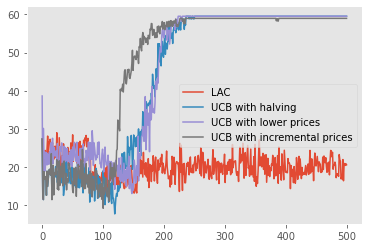

In [21]:
for i in range(num_of_exp):
    plt.plot(np.arange(T), rewards[i], label = exp_names[i])
plt.legend()
plt.show()

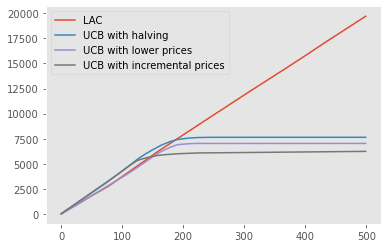

In [23]:
for i in range(num_of_exp):
    plt.plot(np.arange(T), np.cumsum(surplus_opt - rewards[i]), label = exp_names[i])
plt.legend()
plt.show()